# r5r: Accounting for monetary costs

This tutorial shows how to configure and use custom fare rules in order to account for monetary travel costs when generating travel time matrices and accessibility estimates with the `r5r` package.

```{admonition} Credits:

This tutorial is a direct copy from [r5r -documentation](https://ipeagit.github.io/r5r/articles/fare_structure.html) made by r5r contributors.
```

## Getting started

### Run these codes in Binder

Before you can run this Notebook, and/or do any programming, you need to launch the Binder instance. You can find buttons for activating the python environment at the top-right of this page which look like this:

![Launch Binder](../img/launch_binder.png)

### Working with Jupyter Notebooks

Jupyter Notebooks are documents that can be used and run inside the JupyterLab programming environment containing the computer code and rich text elements (such as text, figures, tables and links). 

**A couple of hints**:

- You can **execute a cell** by clicking a given cell that you want to run and pressing <kbd>Shift</kbd> + <kbd>Enter</kbd> (or by clicking the "Play" button on top)
- You can **change the cell-type** between `Markdown` (for writing text) and `Code` (for writing/executing code) from the dropdown menu above. 

See **further details and help for** [**using Notebooks and JupyterLab from here**](https://pythongis.org/part1/chapter-01/nb/04-using-jupyterlab.html). 



## 1. Introduction

Considering the monetary costs of public transport trips in the calculation of 
travel time matrices and accessibility estimates is a major challenge faced by 
researchers and planning practitioners. Each public transport system can have 
its own set of rules for calculating fares, with varying levels of complexity. 
Moreover, there are important trade offs between travel time and monetary costs 
across multiple trip alternatives and are currently not captured by any 
multimodal routing engine, except for R5.

R5 has native capabilities and an open architecture for creating and including 
fare structures in routing models, making it possible to estimate travel time 
matrices and accessibility estimates simultaneously considering different 
combinations of time and monetary cost cutoffs. The main challenge, however, is 
that a specific fare structure for each city needs to be programmed in Java and 
tightly integrated into R5, making this functionality out of reach for those who 
do not know how to code in Java (i.e. most of us!).

To help tackle this challenge, `r5r` has a simple generic rule-based fare 
structure that can be configured via a predefined set of properties and rules 
that can be set directly from R or using external tools such as text editors and
spreadsheets. This approach currently available in `r5r` is able to account for 
the monetary costs of public transport systems that follow a simple set of fare 
rules according to which the cost of a journey depends on combinations of modes 
(see details below).

**This tutorial shows the features of `r5r`s fare structure. It also uses a 
reproducible example to demonstrate how to configure the fare structure to 
account for monetary costs when generating travel time matrices and accessibility 
estimates with `r5r`**. 

### 1.1 Details

A common feature among many public transport services is the possibility of 
discounted transfers, when passengers can use a single ticket for a trip composed 
of multiple rides sometimes combining different transport modes. Such trips usually 
come with a discount in the second or subsequent fares, as well as a limit on the 
number of discounted transfers the user can make and/or a time limit for using that 
discount. This is the type of fare structure currently covered by `r5r`.

We acknowledge that there are several types fare rules that vary from one public 
transport system to another. According to these rules, the cost of a journey can 
differ, for example, depending on: different costs for each trip leg, transport 
mode or route; distance- or zone-based fares; different fares for types of riders 
(e.g elderly people or students) or time of the day (e.g. peak and off-peak hours); 
among many others rules. As such, taking all of these possible rules into 
consideration when calculating the monetary cost of multimodal can be quite 
difficult. `r5r` currently does not cover these more complex fare rules.

The fare calculator currently available in `r5r` is not intended to be a robust 
solution that can take into consideration all public transport systems and their 
specific fare rules. That would be a Herculean task. The features included in 
`r5r`'s fare calculator are inspired by our empirical observations of Brazilian 
public transport systems, and is meant to be used mainly in the [Access to Opportunities project](https://www.ipea.gov.br/acessooportunidades/en/). Everyone else is welcome to use it, if the current features suit their needs.
obs. The GTFS format has some features for specifying public transport fares, but
those features are quite limited and are not enough for adequately representing 
many use cases. A new version of that specification is currently being developed 
[Fares V2](https://github.com/google/transit/issues/252), but it may take some 
time for it to be approved and for transport agencies actually start providing 
GTFS feeds with full fare information.


## 2. Reprex: the public transport system of Porto Alegre
In this tutorial, we will be using the sample data set for the city of Porto 
Alegre (Brazil) included in `r5r`.  Before we start, we need to increase the memory available to Java and load the packages used in this tutorial


In [1]:
# Install h3jsr package
install.packages('h3jsr')

also installing the dependency ‘tidyr’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
options(java.parameters = "-Xmx5G")
library(r5r)
library(sf)
library(data.table)
library(ggplot2)
library(patchwork)
library(dplyr)
library(h3jsr)

Porto Alegre has a relatively straightforward public transport system, where the vast majority of the population that rely on transit ride buses. The city also has a metropolitan rail service that connects the city center to the neighboring northbound municipalities. That system can be seen in the map below.


Using cached R5 version from /home/hentenka/.conda/envs/mamba/envs/r5/lib/R/library/r5r/jar/r5-v6.7-all.jar


Using cached network.dat from /home/hentenka/.conda/envs/mamba/envs/r5/lib/R/library/r5r/extdata/poa/network.dat



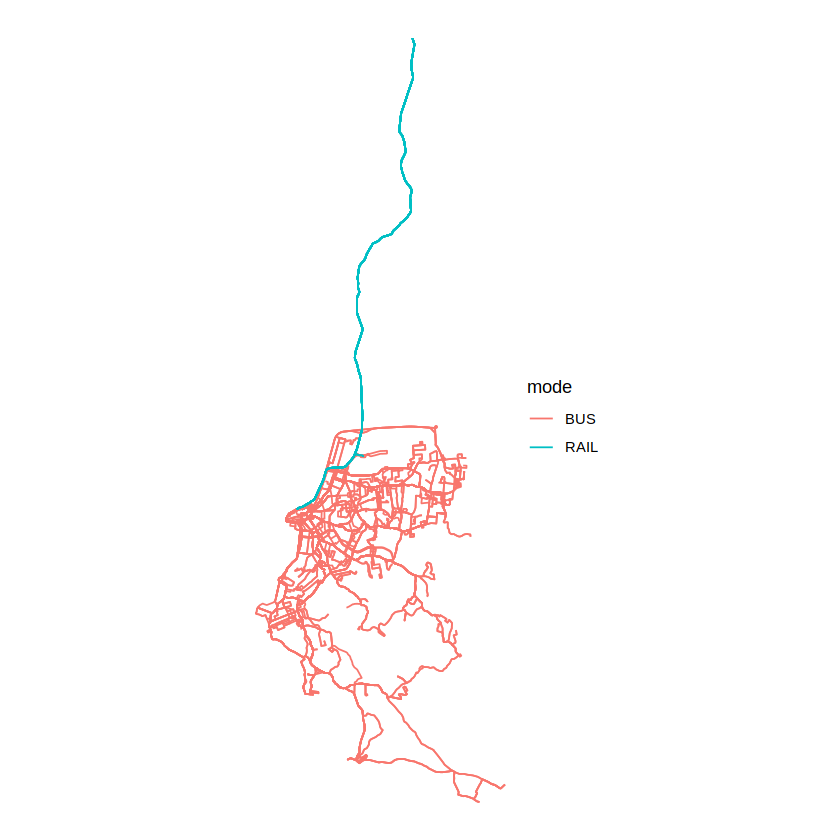

In [3]:
# setup and load Porto Alegre multimodal network into memory
# system.file returns the directory with example data inside the r5r package
# set data path to directory containing your own data if not using the examples
data_path <- system.file("extdata/poa", package = "r5r")
r5r_core <- setup_r5(data_path)

# load transit network as an SF
transit_network <- transit_network_to_sf(r5r_core)

# map
ggplot() +
  geom_sf(data=transit_network$routes, aes(color=mode)) +
  theme_void()

According to the fare rules in Porto Alegre, as in most Brazilian cities, the 
cost a a journey depends on a combination of number of subsequent trips and/or 
transport modes. In the case of Porto Alegre, the fare rules are as follows:

- Each bus ticket costs R\$ 4.80
- Riding a second bus adds R\$ 2.40  to the total cost. 
- Subsequent bus rides cost the full ticket price of R\$ 4.80.
- Each train ticket costs R\$ 4.50. Once a passenger enters a train station, she can take an unlimited amount of train trips as long as she doesn't leave a station.
- The integrated fare between bus and train has a 10% discount, which totals R\$ 8.37.

In the following sections, we will demonstrate how to implement those rules within r5r's fare calculator.


## 3. Setting up the fare structure
There are three support functions in `r5r` to help users configure the fare structure:
-   `setup_fare_structure()` analyses the study area's GTFS and builds a 'skeleton' fare structure structure with the parameters that need to be set;
-   `write_fare_structure()` and `read_fare_structure()` allow saving the current fare structure settings to disk, and reading them back into memory. The settings are saved as standard `.csv` files inside a zipped folder. These files can be edited outside the R session using external text editors and spreadsheet software, for user's convenience.
First, we need to call `setup_fare_structure()`, providing three parameters: the
current `r5r_core` object, a `base_fare` used to populate the fare structure, and
the `by` parameters that identifies what is the main property of the route that 
defines the different fares.
In the example below, the `base_fare` is the standard bus ticket price of R\$ 4.80. 
We are also stating that `by = "MODE"`, so that each transport mode has its own 
fares and integration rules. Users can also create a fare structure where fare 
rules of routes differ by `"AGENCY_ID"` or `"AGENCY_NAME"`, or simply set `by = "GENERIC"` when the entire system follows the same rules.


In [4]:
fare_structure <- setup_fare_structure(r5r_core, 
                                       base_fare = 4.8,
                                       by = "MODE")

Now let's check the contents of the `fare_structure` object. We can see below that it is simply a `list` with a few properties and data.frames.


In [5]:
head(fare_structure, n=7)

$max_discounted_transfers
[1] 1

$transfer_time_allowance
[1] 120

$fare_cap
[1] Inf

$fares_per_type
   type unlimited_transfers allow_same_route_transfer use_route_fare fare
1:  BUS               FALSE                     FALSE          FALSE  4.8
2: RAIL               FALSE                     FALSE          FALSE  4.8

$fares_per_transfer
   first_leg second_leg fare
1:       BUS        BUS  4.8
2:      RAIL        BUS  4.8
3:       BUS       RAIL  4.8
4:      RAIL       RAIL  4.8

$fares_per_route
     agency_id                                 agency_name  route_id
  1:      EPTC Empresa Publica de Transportes e Circulação      1112
  2:      EPTC Empresa Publica de Transportes e Circulação       149
  3:      EPTC Empresa Publica de Transportes e Circulação       165
  4:      EPTC Empresa Publica de Transportes e Circulação       168
  5:      EPTC Empresa Publica de Transportes e Circulação       173
 ---                                                                
113:      EPTC Empresa Publica de Transportes e Circulação        T9
114:      EPTC Empresa Publica de Transportes e Circulação      TR60
115:      EPTC Empresa Publica de Transportes e Circulação      TR62
116:     TRENS                                    TRENSURB    LINHA1
117:     TRENS                                    TRENSURB LINHAAERO
     route_short_name                           route_long_name mode route_fare
  1:             1112                         HIPICA / TRISTEZA  BUS        4.8
  2:              149                                    ICARAI  BUS        4.8
  3:              165                                     COHAB  BUS        4.8
  4:              168                  BELEM NOVO(VIA TRISTEZA)  BUS        4.8
  5:              173                                   CAMAQUA  BUS        4.8
 ---                                                                           
113:               T9                                       PUC  BUS        4.8
114:             TR60                         TRONCAL TRI‘NGULO  BUS        4.8
115:             TR62                          TRONCAL BALTAZAR  BUS        4.8
116:           LINHA1 ESTACAO MERCADO ATE ESTACAO NOVO HAMBURGO RAIL        4.8
117:             AREO                        AEROMOVEL TRENSURB RAIL        4.8
     fare_type
  1:       BUS
  2:       BUS
  3:       BUS
  4:       BUS
  5:       BUS
 ---          
113:       BUS
114:       BUS
115:       BUS
116:      RAIL
117:      RAIL

$debug_settings
$debug_settings$output_file
[1] ""

$debug_settings$trip_info
[1] "MODE"

### 3.1 Global Properties

Let's configure the global properties first, which are the ones that are applied 
to the entire system. 

#### `max_discounted_transfers`

Note that `max_discounted_transfers` is set to 1 by default. This means that the 
passenger gets a fare discount in the first transfer between buses, but she would 
pay the full fare price in subsequent transfers. 

#### `transfer_time_allowance`

By default, `transfer_time_allowance` is set to 120 minutes. We have to set it to 
60 minutes to fit our use case (passengers have 60 minutes to take the second bus 
on a discounted fare, otherwise a full fare is charged).

#### `fare_cap`

Finally, the `fare_cap` setting indicates if there is a maximum value that can be 
charged in a trip, beyond which all subsequent rides are free of charge. In this 
example, we can leave `fare_cap` set to its default `Inf` value because this 
feature is not applicable to Porto Alegre.
Here is how we can check or update the values of these components:

In [6]:
fare_structure$max_discounted_transfers
fare_structure$transfer_time_allowance <- 60 # update transfer_time_allowance
fare_structure$fare_cap

[1] 1

[1] Inf

### 3.2 Configure fares by transport mode
To configure mode-, transfer-, and route-specific properties, we can use the three `data.frames` inside our `fare_structure` list. Let's configure the modes first. 
Below, we can see that the `fares_per_type` data.frame contains five columns:

-   `mode`: the transport mode to which rules on each row refer to;
-   `unlimited_transfers`: a logical value `TRUE` or `FALSE` that indicates if that transport mode allows unlimited transfers between trips of the same mode, such as a metro/subway system where the passenger pays a fare to access a station and then can use as many services as she wants as long as she doesn't exit the system;
-   `allow_same_route_transfer`: a logical value indicating if a discounted transfer can be done between vehicles ??? of the same route;
-   `use_route_fare`: another logical value that indicates if each route will have its own fare, or if all routes in this mode will use the fare indicated in this table;
-   `fare`: the full fare price of this mode.

In [7]:
fare_structure$fares_per_type

type,unlimited_transfers,allow_same_route_transfer,use_route_fare,fare
<chr>,<lgl>,<lgl>,<lgl>,<dbl>
BUS,FALSE,FALSE,FALSE,4.8
RAIL,FALSE,FALSE,FALSE,4.8


We need to do a few small changes in the `fares_per_type` table to accomodate the
fare rules of Porto Alegre. In the `"RAIL"` mode, we need to set `unlimited_transfers`
and `allow_same_route_transfer` to `TRUE`, and update `fare` to 4.50. In the `"BUS"` 
mode, we can let the `allow_same_route_transfer` set to its default `FALSE` value, 
because even though there is a discount for transfers between buses (which is set 
in the following section), that discount is not valid when transferring between 
buses within the same route (for example, from bus route T1 to another T1). We'll 
do those changes below, using `data.table` notation.

In [8]:
fare_structure$fares_per_type[type == "RAIL", unlimited_transfers := TRUE]
fare_structure$fares_per_type[type == "RAIL", fare := 4.50]
fare_structure$fares_per_type[type == "RAIL", allow_same_route_transfer := TRUE]

Checking the results below, everything looks OK:

In [9]:
fare_structure$fares_per_type

type,unlimited_transfers,allow_same_route_transfer,use_route_fare,fare
<chr>,<lgl>,<lgl>,<lgl>,<dbl>
BUS,FALSE,FALSE,FALSE,4.8
RAIL,TRUE,TRUE,FALSE,4.5


### 3.3 Configure fares by transfers

The fare rules for transfer are stored in the `fares_per_transfer` data.frame, 
which is shown below. Each row contains the fare prices for transfers between the
modes specified in `first_leg` and `second_leg` columns.

In [10]:
fare_structure$fares_per_transfer

first_leg,second_leg,fare
<chr>,<chr>,<dbl>
BUS,BUS,4.8
RAIL,BUS,4.8
BUS,RAIL,4.8
RAIL,RAIL,4.8


Let's update `fare_per_transfer` to account for the actual integration rules in 
Porto Alegre.
-   The fare for "BUS" to "BUS" integration is composed of 4.80 for the first leg plus 2.40 for the second leg, which equals to a total fare of 7.20.


In [11]:
# conditional update fare value
fare_structure$fares_per_transfer[first_leg == "BUS" & second_leg == "BUS", fare := 7.2]


- Transfers between "BUS" and "RAIL" (in any direction) cost 8.37, once the 10% discount is applied. Let's make a final update in the data.frame to account for that.


In [12]:
# conditional update fare value
fare_structure$fares_per_transfer[first_leg != second_leg, fare := 8.37]

# use fcase instead ?
fare_structure$fares_per_transfer[, fare := fcase(first_leg == "BUS" & second_leg == "BUS", 7.2,
                                                 first_leg != second_leg, 8.37)]

-   Transfers between "RAIL" and "RAIL" are free and unlimited, which is already 
accounted for in the field `unlimited_transfers` of the `fare_per_mode` table. 
Thus, the equivalent row of the `fare_per_transfer` data.frame needs to be removed. 
If we leave the that row in `fare_per_transfer`, transfers between "RAIL" and "RAIL" 
will count to the global `max_discounted_transfers` allowance.


In [13]:
# remove row
fare_structure$fares_per_transfer <- fare_structure$fares_per_transfer[!(first_leg == "RAIL" & second_leg == "RAIL")]


Once all changes are applied, the `fare_per_transfer` data.frame should look like 
this:

In [14]:
fare_structure$fares_per_transfer

first_leg,second_leg,fare
<chr>,<chr>,<dbl>
BUS,BUS,7.20
RAIL,BUS,8.37
BUS,RAIL,8.37


### 3.4 Routes configuration

The information on the fare price for each route is stored in the `fares_per_route` 
data.frame. Below, we can see a sample of the bus and train routes in Porto Alegre. 
In case there a few special routes (e.g. express services) with specific fares, 
these values can be updated in this `fares_per_route` data.frame.



In [15]:
tail(fare_structure$fares_per_route)

agency_id,agency_name,route_id,route_short_name,route_long_name,mode,route_fare,fare_type
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
EPTC,Empresa Publica de Transportes e Circulação,T8,T8,CAMPUS / FARRAPOS,BUS,4.8,BUS
EPTC,Empresa Publica de Transportes e Circulação,T9,T9,PUC,BUS,4.8,BUS
EPTC,Empresa Publica de Transportes e Circulação,TR60,TR60,TRONCAL TRI‘NGULO,BUS,4.8,BUS
EPTC,Empresa Publica de Transportes e Circulação,TR62,TR62,TRONCAL BALTAZAR,BUS,4.8,BUS
TRENS,TRENSURB,LINHA1,LINHA1,ESTACAO MERCADO ATE ESTACAO NOVO HAMBURGO,RAIL,4.8,RAIL
TRENS,TRENSURB,LINHAAERO,AREO,AEROMOVEL TRENSURB,RAIL,4.8,RAIL


Basic route information is taken directly from the GTFS data (agency, route id 
and names, mode, etc), but the `route_fare` and `fare_type` columns were added 
specifically for the `r5r` fare structure.

-   `route_fare`: is used to set a specific fare for each route. This field can 
be used to represent services that have many unique fares, such as metropolitan 
/ suburban trains and buses. This is used together with the `use_route_fare` 
column in the `fares_per_type` table: the `route_fare` field is only considered 
by the `r5r` fare structure when `use_route_fare` of that mode is set to `TRUE`.

-   `fare_type`: is used to link each route with information in the `fares_per_type` 
and `fares_per_transfer` tables. In this example, `fare_type` is always the same 
as `mode`, because that was what we chose in the `by` parameter when calling `setup_fare_structure` earlier (we could have chosen to discriminate fares by 
agency, for example).

We actually don't have any change do to in the `fares_per_route` table, in this 
example. It does not matter that the `route_fare` value is wrong for the "RAIL" 
lines, because we are using the fares set in `fares_per_type` and `fares_per_transfer` 
which we already set up correctly before.
Now that our `fare_structure` is complete, we can use it to calculate travel time 
matrices and accessibility while accounting for monetary cost cutoffs. Let's see 
how it's done in the next sections.

## 4. Calculating travel time and accessibiilty accounting for monetary costs
The `travel_time_matrix()` and `accessibility()` functions have two new parameters 
to account for monetary costs thresholds:
-   `fare_structure`: the settings object that we've been working on.
-   `max_fare`: the maximum total fare that can be used in the trip.

### 4.1 Travel time with monetary cost

The following example shows travel time differences when monetary costs are 
accounted for, using the `travel_time_matrix()` function.

In [16]:
## load input data
points <- read.csv(system.file("extdata/poa/poa_hexgrid.csv", package = "r5r"))

# calculate travel times function
calculate_travel_times <- function(fare) {

  ttm_df <- travel_time_matrix(r5r_core,
                               origins = points,
                               destinations = points,
                               departure_datetime = as.POSIXct("13-05-2019 14:00:00",
                                                               format = "%d-%m-%Y %H:%M:%S"),
                               mode = c("WALK", "TRANSIT"),
                               fare_structure = fare_structure,
                               max_fare = fare,
                               max_trip_duration = 45,
                               max_walk_time = 30)

  return(ttm_df)
}


# calculate travel times, and combine results
ttm <- calculate_travel_times(fare = Inf)
ttm_500 <- calculate_travel_times(fare = 5)

# merge results
ttm[ttm_500, on = .(from_id, to_id), travel_time_500 := i.travel_time_p50]
ttm[, travel_time_unl := travel_time_p50]
ttm[, travel_time_p50 := NULL]

Loading required namespace: testthat



Below, we can see a sample of the travel time differences with and without monetary 
cost restriction. We can see that some trips are not affected at all (`travel_time_unl == travel_time_500`), some trips take a little longer to complete (`travel_time_500 > travel_time_unl`), and other trips cannot be completed at all (`travel_time_500 == NA`).


In [17]:
tail(ttm, 10)

from_id,to_id,travel_time_500,travel_time_unl
<chr>,<chr>,<int>,<int>
89a90166da7ffff,89a90129c2bffff,38,36
89a90166da7ffff,89a90129aa7ffff,33,30
89a90166da7ffff,89a90e93497ffff,32,32
89a90166da7ffff,89a90129807ffff,39,38
89a90166da7ffff,89a90129b5bffff,34,34
89a90166da7ffff,89a90129dd7ffff,37,37
89a90166da7ffff,89a90129bbbffff,33,33
89a90166da7ffff,89a90129bd7ffff,26,26
89a90166da7ffff,89a90129a47ffff,19,19


The plots below show the overall distribution of the travel time differences and 
unreachable destinations:

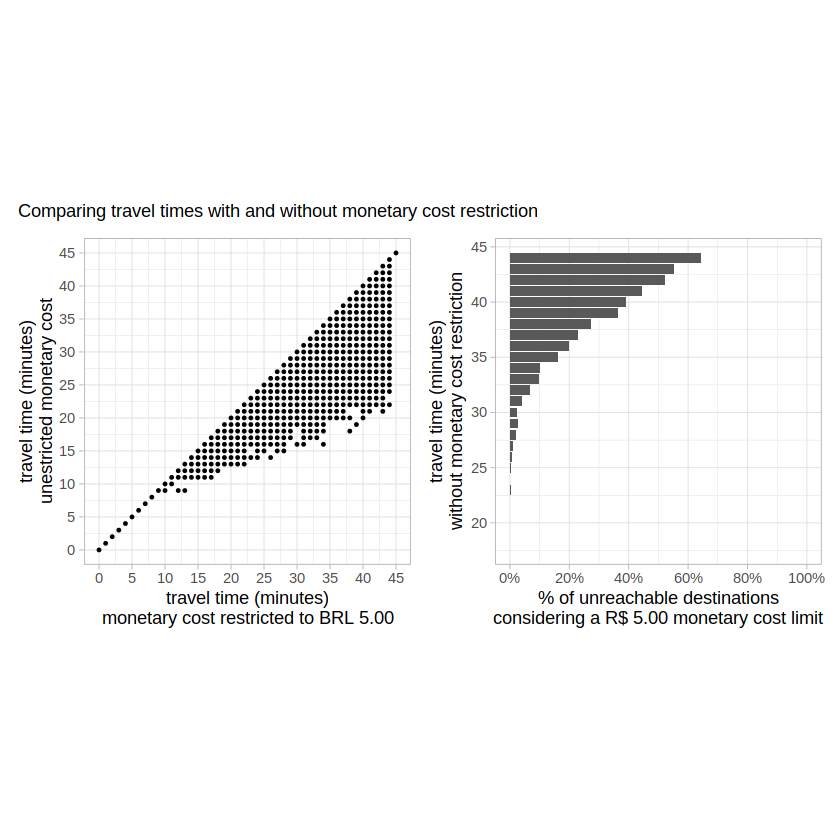

In [18]:
# plot of overall travel time differences between limited and unlimited cost travel time matrices 
time_difference = ttm[!is.na(travel_time_500), .(count = .N), 
                      by = .(travel_time_unl, travel_time_500)]

p1 <- ggplot(time_difference, aes(y = travel_time_unl, x = travel_time_500)) +
  geom_point(size = 0.7) +
  coord_fixed() +
  scale_x_continuous(breaks = seq(0, 45, 5)) +
  scale_y_continuous(breaks = seq(0, 45, 5)) +
  theme_light() +
  theme(legend.position = "none") +
  labs(y = "travel time (minutes)\nunestricted monetary cost",
       x = "travel time (minutes)\nmonetary cost restricted to BRL 5.00"
       )

# plot of unreachable destinations when the monetary cost limit is too low
unreachable <- ttm[, .(count = .N), by = .(travel_time_unl, is.na(travel_time_500))]
unreachable[, perc := count / sum(count, na.rm = T), by = .(travel_time_unl)]
unreachable <- unreachable[is.na == TRUE]
unreachable <- na.omit(unreachable)

p2 <- ggplot(unreachable, aes(x=travel_time_unl, y=perc)) +
  geom_col() +
  coord_flip() +
  scale_x_continuous(breaks = seq(0, 45, 5)) +
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.2), 
                     labels = paste0(seq(0, 100, 20), "%")) +
  theme_light() +
  labs(x = "travel time (minutes)\nwithout monetary cost restriction",
       y = "% of unreachable destinations\nconsidering a R$ 5.00 monetary cost limit")

# combine both plots using patchwork
p1 + p2 + plot_annotation(subtitle = "Comparing travel times with and without monetary cost restriction")

### 4.2 Calculating accessibility with monetary cost

Now, we can answer questions like "how many health care facilities one can access 
in 60 minutes using public transport, on a R\$5.00 budget?". We'll do that below, 
and compare the results the accessibility unconstrained by monetary costs: 

In [19]:
# calculate accessibility function
calculate_accessibility <- function(fare, fare_string) {
  access_df <- accessibility(r5r_core,
                             origins = points,
                             destinations = points,
                             departure_datetime = as.POSIXct("13-05-2019 14:00:00",
                                                             format = "%d-%m-%Y %H:%M:%S"),
                             opportunities_colname = "healthcare",
                             mode = c("WALK", "TRANSIT"),
                             cutoffs = c(60),
                             fare_structure = fare_structure,
                             max_fare = fare,
                             max_trip_duration = 45,
                             max_walk_time = 30,
                             progress = FALSE)
  access_df$max_fare <- fare_string
  return(access_df)
}
# calculate accessibility, combine results, and convert to SF
access_500 <- calculate_accessibility(fare=5, fare_string="R$ 5.00 budget")
access_unl <- calculate_accessibility(fare=Inf, fare_string="Unlimited budget")
access <- rbind(access_500, access_unl)
# bring geometry
access$geometry <- h3jsr::cell_to_polygon(access$id)
access <- st_as_sf(access)

Finally, we can plot the results and see how accessibility levels can differ 
quite substantially when we account for monetary costs. 

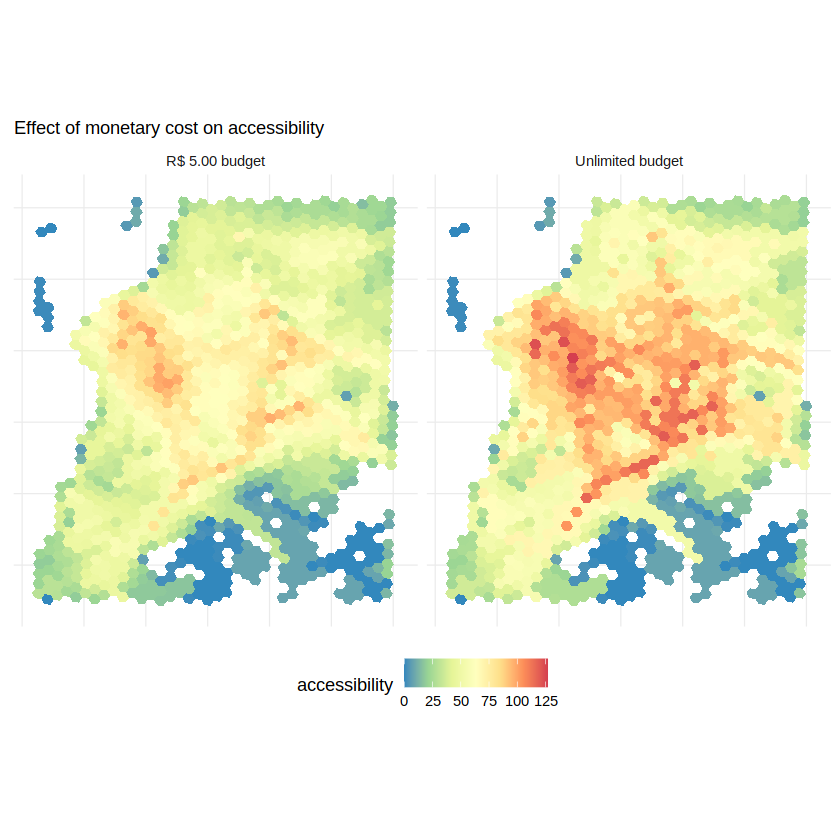

In [20]:
# plot accessibility maps
ggplot(data = access) +
  geom_sf(aes(fill = accessibility), color=NA, size = 0.2) +
  scale_fill_distiller(palette = "Spectral") +
  facet_wrap(~max_fare) +
  labs(subtitle = "Effect of monetary cost on accessibility") +
  theme_minimal() +
  theme(legend.position = "bottom",
        axis.text = element_blank())


If you have any suggestions or want to report an error, please visit [the package GitHub page](https://github.com/ipeaGIT/r5r).